In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install hmmlearn 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 13.4 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


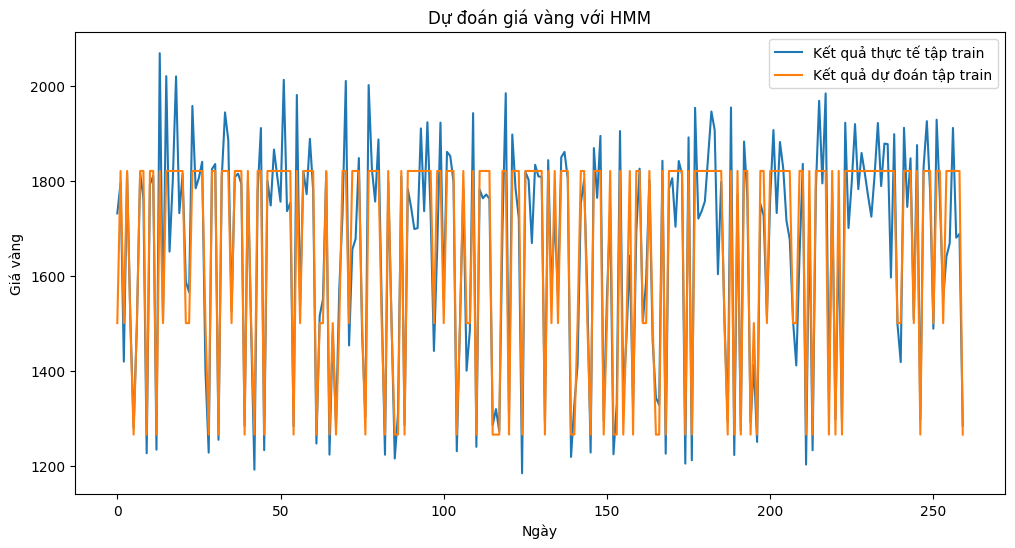

In [ ]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

# Đọc dữ liệu từ tệp CSV
data = pd.read_csv('/content/drive/MyDrive/PTDLKD/Data/Gold_Data.csv')


# Flip the column
data = data.iloc[::-1]

# Format column Price to float
data['Price'] = data.Price.str.replace(',','').astype(float)


# Chỉ lấy cột giá đóng cửa
closing_prices = data['Price'].values.reshape(-1, 1)

# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập xác thực
train_data, temp_data = train_test_split(closing_prices, test_size=0.3, random_state=42)
test_data, validate_data = train_test_split(temp_data, test_size=0.33, random_state=42)

# Tạo và huấn luyện mô hình HMM với tập huấn luyện
model = GaussianHMM(n_components=3, covariance_type='diag', n_iter=1000)


model.fit(train_data)
# Dự đoán trạng thái ẩn cho tập kiểm tra
hidden_states = model.predict(test_data)

# Vẽ biểu đồ kết quả thực tế và dự đoán
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(range(len(test_data)), test_data, label='Kết quả thực tế tập train')
plt.plot(range(len(test_data)), [model.means_[state][0] for state in hidden_states], label='Kết quả dự đoán tập train')
plt.xlabel('Ngày')
plt.ylabel('Giá vàng')
plt.title('Dự đoán giá vàng với HMM')
plt.legend()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


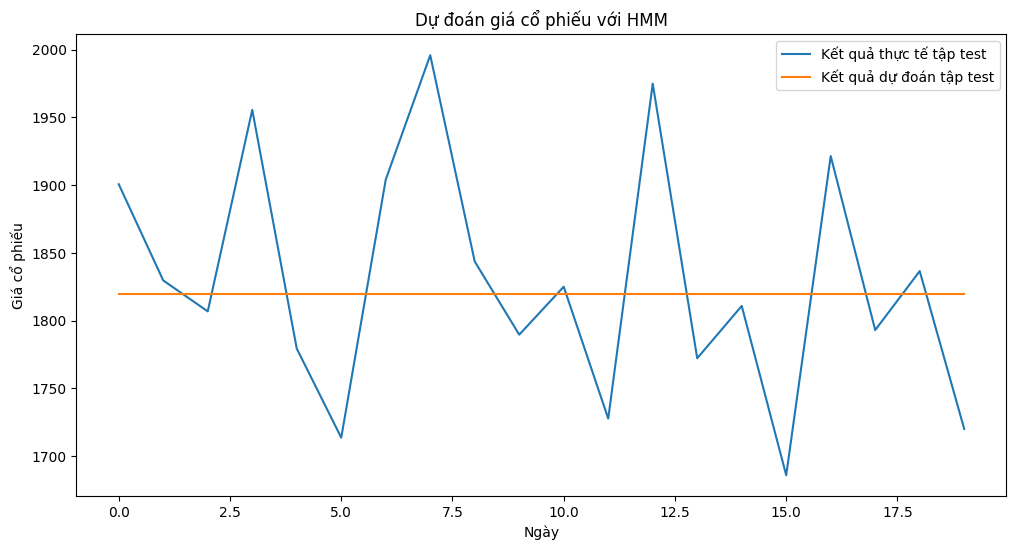

In [ ]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

# Đọc dữ liệu từ tệp CSV
data = pd.read_csv('/content/drive/MyDrive/PTDLKD/Data/Gold_Data.csv')

# Flip the column
data = data.iloc[::-1]

# Format column Price to float
data['Price'] = data.Price.str.replace(',','').astype(float)


# Chỉ lấy cột giá đóng cửa
closing_prices = data['Price'].values.reshape(-1, 1)

# 4. Chia train test
train_size = int(0.7 * len(data['Price']))
Test_size = int(0.2 * len(data['Price']))
val_size = len(data['Price']) - train_size - Test_size

train_data = closing_prices[:train_size]
test_data = closing_prices[train_size:train_size+Test_size]
val_data = closing_prices[train_size+Test_size:]

# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập xác thực
train_data, temp_data = train_test_split(test_data, test_size=0.1, random_state=42)
Test_data, validate_data = train_test_split(temp_data, test_size=0.2, random_state=42)

# Tạo và huấn luyện mô hình HMM với tập huấn luyện
model = GaussianHMM(n_components=3, covariance_type='diag', n_iter=1000)
model.fit(train_data)

# Dự đoán trạng thái ẩn cho tập kiểm tra
hidden_states = model.predict(Test_data)

# Vẽ biểu đồ kết quả thực tế và dự đoán
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(range(len(Test_data)), Test_data, label='Kết quả thực tế tập test')
plt.plot(range(len(Test_data)), [model.means_[state][0] for state in hidden_states], label='Kết quả dự đoán tập test')
plt.xlabel('Ngày')
plt.ylabel('Giá cổ phiếu')
plt.title('Dự đoán giá cổ phiếu với HMM')
plt.legend()
plt.show()


In [ ]:
# Tính toán các độ đo
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(Test_data, [model.means_[state][0] for state in hidden_states]))
mape = mean_absolute_percentage_error(Test_data, [model.means_[state][0] for state in hidden_states]) * 100
mse = mean_squared_error(Test_data, [model.means_[state][0] for state in hidden_states])

# In kết quả
print("RMSE:", rmse)
print("MAPE:", mape)
print("MSE:", mse)

RMSE: 87.08616500818619
MAPE: 3.760633208290705
MSE: 7584.000135833031


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


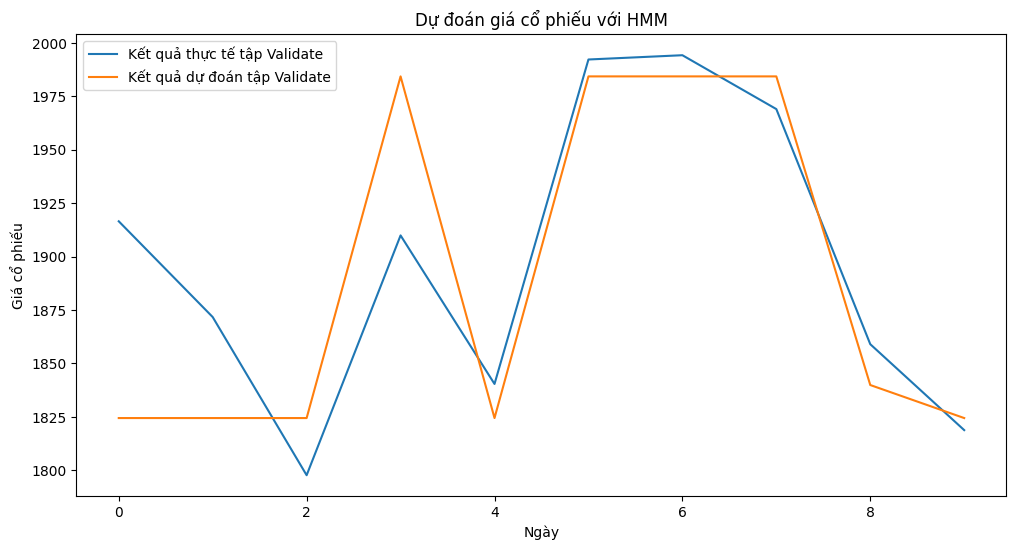

In [ ]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

# Đọc dữ liệu từ tệp CSV
data = pd.read_csv('/content/drive/MyDrive/PTDLKD/Data/Gold_Data.csv')

# Flip the column
data = data.iloc[::-1]

# Format column Price to float
data['Price'] = data.Price.str.replace(',','').astype(float)

# Chỉ lấy cột giá đóng cửa
closing_prices = data['Price'].values.reshape(-1, 1)

# 4. Chia train test
train_size = int(0.7 * len(data['Price']))
Test_size = int(0.2 * len(data['Price']))
val_size = len(data['Price']) - train_size - Test_size

train_data = closing_prices[:train_size]
test_data = closing_prices[train_size:train_size+Test_size]
val_data = closing_prices[train_size+Test_size:]

# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập xác thực
train_data, temp_data = train_test_split(val_data, test_size=0.1, random_state=42)
Val_data, validate_data = train_test_split(temp_data, test_size=0.2, random_state=42)

# Tạo và huấn luyện mô hình HMM với tập huấn luyện
model = GaussianHMM(n_components=3, covariance_type='diag', n_iter=1000)
model.fit(train_data)

# Dự đoán trạng thái ẩn cho tập kiểm tra
hidden_states = model.predict(Val_data)

# Vẽ biểu đồ kết quả thực tế và dự đoán
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(range(len(Val_data)), Val_data, label='Kết quả thực tế tập Validate')
plt.plot(range(len(Val_data)), [model.means_[state][0] for state in hidden_states], label='Kết quả dự đoán tập Validate')
plt.xlabel('Ngày')
plt.ylabel('Giá cổ phiếu')
plt.title('Dự đoán giá cổ phiếu với HMM')
plt.legend()
plt.show()


In [ ]:
# Tính toán các độ đo
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(Val_data, [model.means_[state][0] for state in hidden_states]))
mape = mean_absolute_percentage_error(Val_data, [model.means_[state][0] for state in hidden_states]) * 100
mse = mean_squared_error(Val_data, [model.means_[state][0] for state in hidden_states])

# In kết quả
print("RMSE:", rmse)
print("MAPE:", mape)
print("MSE:", mse)


RMSE: 42.42952233309533
MAPE: 1.6586071650891303
MSE: 1800.2643654146354


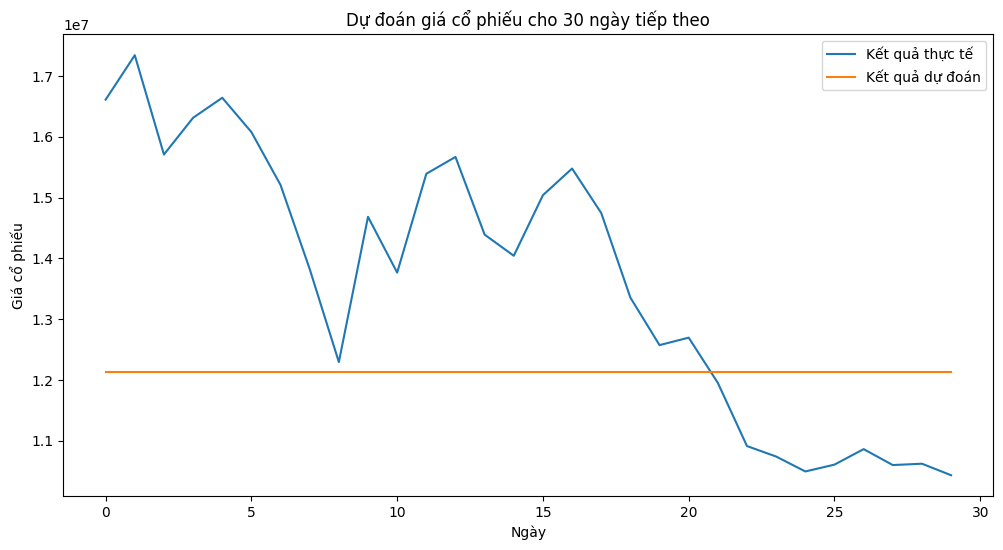

In [ ]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

# Đọc dữ liệu từ tệp CSV
data = pd.read_csv('/content/ETS.csv')

# Flip the column
data = data.iloc[::-1]

# Format column Price to float
# data['VND'] = data.VND.str.replace(',','').astype(float)

# Chỉ lấy cột giá đóng cửa
closing_prices = data['VND'].values.reshape(-1, 1)

# Tạo và huấn luyện mô hình HMM với toàn bộ dữ liệu
model = GaussianHMM(n_components=3, covariance_type='diag', n_iter=1000)
model.fit(closing_prices)

# Dự đoán trạng thái ẩn cho 30 ngày tiếp theo
predicted_states = model.predict(closing_prices[-30:])

# Dự đoán giá cổ phiếu dựa trên trạng thái ẩn
predicted_prices = [model.means_[int(state)][0] for state in predicted_states]

# In ra dự đoán giá cổ phiếu
# print("Dự đoán giá cổ phiếu cho 30 ngày tiếp theo:")
# for i, price in enumerate(predicted_prices, 1):
#     print("Ngày {}: Giá dự đoán: {}".format(i, price))

# Vẽ biểu đồ kết quả thực tế và dự đoán
actual_prices = closing_prices[-30:]
# print(actual_prices)
# print(range(len(actual_prices)))

plt.figure(figsize=(12, 6))
plt.plot(range(len(actual_prices)), actual_prices, label='Kết quả thực tế')
plt.plot(range(len(actual_prices)), predicted_prices, label='Kết quả dự đoán')
plt.xlabel('Ngày')
plt.ylabel('Giá cổ phiếu')
plt.title('Dự đoán giá cổ phiếu cho 30 ngày tiếp theo')
plt.legend()
plt.show()

In [ ]:
# Tính toán các độ đo
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mape = mean_absolute_percentage_error(actual_prices, predicted_prices) * 100
mse = mean_squared_error(actual_prices, predicted_prices)

# In kết quả
print("RMSE:", rmse)
print("MAPE:", mape)
print("MSE:", mse)

Unique states:
[1 0 2]
